# Stacking
***

# Import

In [4]:
from glob import glob
import re 
import numpy as np
import pandas as pd
np.random.seed(0) # ensure reproducibility
np.set_printoptions(suppress = True)
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
# Models
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# NN
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Stacking
from vecstack import stacking

import warnings
warnings.filterwarnings('ignore')

# Prepare data

In [6]:
wd = '/Users/ewenwang/Documents/practice_data/conversion_rate/'
test_file = ['round1_ijcai_18_test_a_20180301.txt', 'round1_ijcai_18_test_b_20180418.txt']

file_UISC_union = 'snow_data_UISC_union.txt'
cvr_sm_union = 'cvr_bayesianSM_union.txt'
pagerank_union = 'pagerank_union.txt'

output_file = 'result.txt'

data = pd.read_csv(wd+file_UISC_union, sep=' ')
data = data.merge(pd.read_csv(wd+pagerank_union, sep=' '), on='instance_id', how='left').merge(pd.read_csv(wd+cvr_sm_union, sep=' '), on='instance_id', how='left')

target = 'is_trade'
drop_list = ['is_trade', 'item_category_list', 'item_property_list', 'predict_category_property', 'realtime', 'context_timestamp']
features = [x for x in data.columns if x not in drop_list]

test_day = 24
train = data[(data['day'] >= 18) & (data['day'] < test_day)]
test = data[(data['day'] == test_day)]
        
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

n_classes = 2

print('Train shape:', X_train.shape)
print('Test shape: ', X_test.shape)

Train shape: (422660, 333)
Test shape:  (57588, 333)


# Initialize 1st level models

In [22]:
def build_keras_model_1():
    model = Sequential()
    model.add(Dense(64, 
                    input_dim=X_train.shape[1], 
                    kernel_initializer='normal', 
                    activation='relu'))
    model.add(Dense(1, 
                    kernel_initializer='normal', 
                    activation='sigmoid'))
    model.compile(optimizer='rmsprop', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

# Caution! All models and parameter values are just 
# demonstrational and shouldn't be considered as recommended.
models_1 = [ 
    GaussianNB(),
    
    LogisticRegression(random_state=0),
    
    ExtraTreesClassifier(random_state=0, n_jobs=-1, n_estimators=100, max_depth=3),
                         
    RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=1000, max_depth=3),
        
    XGBClassifier(learning_rate=0.01, n_estimators=1000, max_depth=3),
                  
    LGBMClassifier(random_state=0, n_jobs=-1, learning_rate=0.01, n_estimators=1000, max_depth=4),
                  
    KerasClassifier(build_fn=build_keras_model_1, epochs=50, batch_size=32, verbose=0)
]

# Perform stacking

In [23]:
S_train_1, S_test_1 = stacking(models_1,                   # list of models
                               X_train.fillna(0), y_train.fillna(0), X_test.fillna(0),   # data
                               regression=False,           # classification task (if you need 
                                                           #     regression - set to True)
                               mode='oof_pred',            # mode: oof for train set, fit on full 
                                                           #     train and predict test set once
                               needs_proba=True,           # predict probabilities (if you need 
                                                           #     class labels - set to False) 
                               save_dir='.',               # save result and log in current dir 
                                                           #     (to disable saving - set to None)
                               metric=log_loss,            # metric: callable
                               n_folds=5,                  # number of folds
                               stratified=True,            # stratified split for folds
                               shuffle=True,               # shuffle the data
                               random_state=0,             # ensure reproducibility
                               verbose=2)                  # print all info

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
mode:         [oof_pred]
n_models:     [7]

model  0:     [GaussianNB]
    fold  0:  [0.10414938]
    fold  1:  [0.10413866]
    fold  2:  [0.10405439]
    fold  3:  [0.10408151]
    fold  4:  [0.10403045]
    ----
    MEAN:     [0.10409088] + [0.00004643]
    FULL:     [0.10409088]

    Fitting on full train set...

model  1:     [LogisticRegression]
    fold  0:  [0.13805420]
    fold  1:  [0.13810327]
    fold  2:  [0.13821111]
    fold  3:  [0.13762233]
    fold  4:  [0.13673892]
    ----
    MEAN:     [0.13774596] + [0.00054193]
    FULL:     [0.13774597]

    Fitting on full train set...

model  2:     [ExtraTreesClassifier]
    fold  0:  [0.10034123]
    fold  1:  [0.10040215]
    fold  2:  [0.10012593]
    fold  3:  [0.10007623]
    fold  4:  [0.09998751]
    ----
    MEAN:     [0.10018661] + [0.00015866]
    FULL:     [0.10018661]

    Fitting on full train set...

model  3:     [RandomForestClassifier]


# Look at the result

In [24]:
print('We have %d classes and %d models so in resulting arrays \
we expect to see %d columns.' % (n_classes, len(models_1), n_classes * len(models_1)))
print('S_train_1 shape:', S_train_1.shape)
print('S_test_1 shape: ', S_test_1.shape)

We have 2 classes and 7 models so in resulting arrays we expect to see 14 columns.
S_train_1 shape: (422660, 14)
S_test_1 shape:  (57588, 14)


In [25]:
S_train_1[:2]

array([[0.97541206, 0.02458794, 0.54550544, 0.45449456, 0.97948474,
        0.02051526, 0.97528172, 0.02471828, 0.9924463 , 0.00755368,
        0.99281573, 0.00718427, 0.        , 1.        ],
       [0.97825511, 0.02174489, 0.98888685, 0.01111315, 0.97963651,
        0.02036349, 0.97600819, 0.02399181, 0.9939819 , 0.0060181 ,
        0.99327291, 0.00672709, 1.        , 0.        ]])

In [26]:
S_test_1[:2]

array([[0.97507169, 0.02492831, 0.77959327, 0.22040673, 0.97324503,
        0.02675497, 0.9763691 , 0.0236309 , 0.98846424, 0.01153576,
        0.98945386, 0.01054614, 0.        , 1.        ],
       [0.98036998, 0.01963002, 0.99846575, 0.00153425, 0.98391833,
        0.01608167, 0.98751856, 0.01248144, 0.99601358, 0.00398641,
        0.99631791, 0.00368209, 0.        , 1.        ]])

# Our arrays and log were saved in current dir

In [27]:
names = sorted(glob('*.npy'))
npy_1_name = names[0] # for later use

print('Arrays:')
for name in names:
    print(name)

names = sorted(glob('*.log.txt'))
log_1_name = names[0] # for later use

print('\nLogs:')
for name in names:
    print(name)

Arrays:
[2018.04.21].[18.28.19].066513.d524f8.npy

Logs:
[2018.04.21].[18.28.19].066513.d524f8.log.txt


# Initialize some other 1st level model(s)

As we continue to work on the problem we create many other models.  
Let's say we want to try more powerful neural network.

In [29]:
def build_keras_model_2():
    model = Sequential()
    model.add(Dense(128, 
                    input_dim=X_train.shape[1], 
                    kernel_initializer='normal', 
                    activation='relu'))
    model.add(Dense(64, 
                    kernel_initializer='normal', 
                    activation='relu'))
    model.add(Dense(16, 
                    kernel_initializer='normal', 
                    activation='relu'))
    model.add(Dense(n_classes, 
                    kernel_initializer='normal', 
                    activation='softmax'))
    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'])
    return model

# Caution! All models and parameter values are just 
# demonstrational and shouldn't be considered as recommended.
models_2 = [        
    KerasClassifier(build_fn=build_keras_model_2, epochs=150, batch_size=32, verbose=0),
    LGBMClassifier(random_state=0, 
                   n_jobs=-1, 
                   learning_rate=0.01, 
                   metric='binary_logloss',
                   n_estimators=1700, 
                   max_depth=4, 
                   num_leaves=16,
                   colsample_bytree=0.6, 
                   subsample=0.9)
]

# Perform stacking again

In [31]:
S_train_2, S_test_2 = stacking(models_2,                   # list of models
                               X_train.fillna(0), y_train.fillna(0), X_test.fillna(0),   # data
                               regression=False,           # classification task (if you need 
                                                           #     regression - set to True)
                               mode='oof_pred',            # mode: oof for train set, fit on full 
                                                           #     train and predict test set once
                               needs_proba=True,           # predict probabilities (if you need 
                                                           #     class labels - set to False) 
                               save_dir='.',               # save result and log in current dir 
                                                           #     (to disable saving - set to None)
                               metric=log_loss,            # metric: callable
                               n_folds=5,                  # number of folds
                               stratified=True,            # stratified split for folds
                               shuffle=True,               # shuffle the data
                               random_state=0,             # ensure reproducibility
                               verbose=2)                  # print all info

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
mode:         [oof_pred]
n_models:     [2]

model  0:     [KerasClassifier]
    fold  0:  [0.74607320]
    fold  1:  [0.74607320]
    fold  2:  [33.79310296]
    fold  3:  [0.74568226]
    fold  4:  [33.79309414]
    ----
    MEAN:     [13.96480515] + [16.18973377]
    FULL:     [13.96472696]

    Fitting on full train set...

model  1:     [LGBMClassifier]
    fold  0:  [0.08971688]
    fold  1:  [0.09015472]
    fold  2:  [0.08898464]
    fold  3:  [0.08885866]
    fold  4:  [0.08825006]
    ----
    MEAN:     [0.08919299] + [0.00066988]
    FULL:     [0.08919300]

    Fitting on full train set...

Result was saved to [./[2018.04.22].[05.05.29].603954.4e825d.npy]


# New arrays and log were saved too

In [32]:
names = sorted(glob('*.npy'))

print('Arrays:')
for name in names:
    print(name)
    
names = sorted(glob('*.log.txt'))

print('\nLogs:')
for name in names:
    print(name)

Arrays:
[2018.04.21].[18.28.19].066513.d524f8.npy
[2018.04.22].[05.05.29].603954.4e825d.npy

Logs:
[2018.04.21].[18.28.19].066513.d524f8.log.txt
[2018.04.22].[05.05.29].603954.4e825d.log.txt


# Time to collect results

After several (many) days of building, optimizing, and testing models we have a lot of files with saved OOF.  
At this point we can load and use OOF of specific model or all OOF we have.

# Find specific model

We can open logs and find the model of interest.  
We can do it programmatically or just open logs in editor.  
Name of the `.log.txt` file is the same as the name of corresponding `.npy` file (except extension).  
To find columns containing OOF of specific model we use model index from log:
* if we predicted class labels - corresponding column index is just model index
* if we predicted probabilities - corresponding column index is model index multiplied by number of classes

In [33]:
print("Let's open this log: %s" % log_1_name)
with open(log_1_name) as f:
    lines = f.readlines()

print("Let's look what models did we build in those session.\n")
for line in lines:
    if re.search(r'^model [0-9]+', line):
        print(line)

Let's open this log: [2018.04.21].[18.28.19].066513.d524f8.log.txt
Let's look what models did we build in those session.



# Load specific model OOF

Let's say we are interested in `LGBMClassifier`.  
We found out that it has index 5.  
Then we load target `.npy` file and because of probabilities we need 3 columns from 15 (5 \* 3) to 18 (5 \* 3 + 3)

In [34]:
print("Let's load this .npy file: %s" % npy_1_name)
S = np.load(npy_1_name)
S_train_lgbm = S[0][:, 15:18]
S_test_lgbm = S[1][:, 15:18]

Let's load this .npy file: [2018.04.21].[18.28.19].066513.d524f8.npy


In [35]:
S_train_lgbm[:5]

array([], shape=(5, 0), dtype=float64)

In [36]:
S_test_lgbm[:5]

array([], shape=(5, 0), dtype=float64)

# Compute score of specific model

In [38]:
# print('LGBMCLassifier log loss: %.8f' % log_loss(y_train, S_train_lgbm))

# Load ALL OOF

***Note:*** If you load OOF from scratch, don't forget to load `y_train` from initial dataset too.

In [39]:
print('We have %d classes and %d models TOTAL so in resulting arrays \
we expect to see %d columns.' % (n_classes, len(models_1) + len(models_2), 
                                 n_classes * (len(models_1) + len(models_2))))

We have 2 classes and 9 models TOTAL so in resulting arrays we expect to see 18 columns.


In [40]:
# Create empty arrays
S_train_all = np.zeros((X_train.shape[0], 0))
S_test_all = np.zeros((X_test.shape[0], 0))

# Load results
for name in sorted(glob('*.npy')):
    print('Loading: %s' % name)
    S = np.load(name)
    S_train_all = np.c_[S_train_all, S[0]]
    S_test_all = np.c_[S_test_all, S[1]]
    
print('\nS_train_all shape:', S_train_all.shape)
print('S_test_all shape: ', S_test_all.shape)

Loading: [2018.04.21].[18.28.19].066513.d524f8.npy
Loading: [2018.04.22].[05.05.29].603954.4e825d.npy

S_train_all shape: (422660, 18)
S_test_all shape:  (57588, 18)


# Apply 2nd level model

In [42]:
# Initialize 2nd level model
model = LGBMClassifier(random_state=0, n_jobs=-1, learning_rate=0.01, n_estimators=1700, max_depth=4, 
                   colsample_bytree=0.6, subsample=0.9)
    
# Fit 2nd level model
model = model.fit(S_train_all, y_train)

# Predict
y_pred = model.predict_proba(S_test_all)

# Final prediction score
print('Final prediction score: %.8f' % log_loss(y_test, y_pred))

Final prediction score: 0.08545384


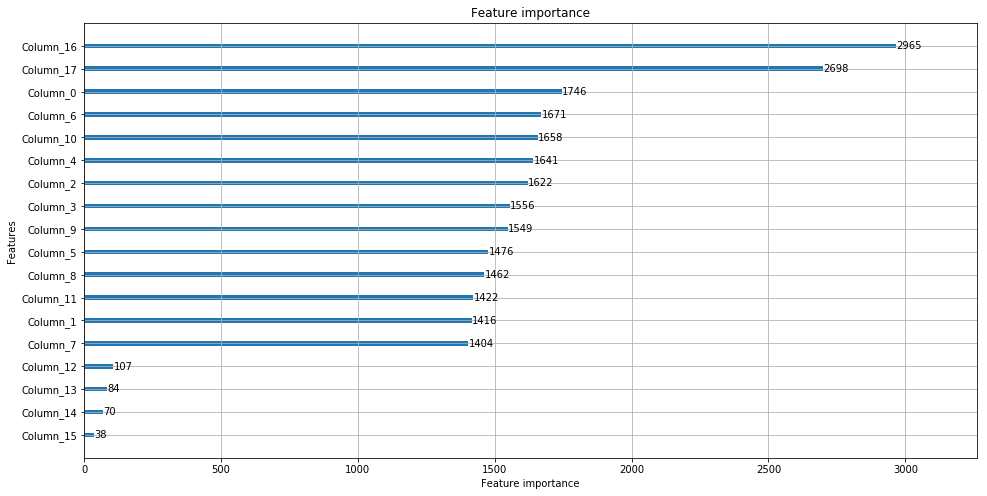

In [44]:
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

lgb.plot_importance(model, figsize=(16, 8))

## Application

Train shape: (480248, 333)
Test shape:  (61245, 333)
task:         [classification]
n_classes:    [2]
metric:       [log_loss]
mode:         [oof_pred]
n_models:     [7]

model  0:     [GaussianNB]
    fold  0:  [0.10271126]
    fold  1:  [0.10270963]
    fold  2:  [0.10267481]
    fold  3:  [0.10263278]
    fold  4:  [0.10262926]
    ----
    MEAN:     [0.10267155] + [0.00003558]
    FULL:     [0.10267155]

    Fitting on full train set...

model  1:     [LogisticRegression]
    fold  0:  [0.13848595]
    fold  1:  [0.13708020]
    fold  2:  [0.13653242]
    fold  3:  [0.13645793]
    fold  4:  [0.13602683]
    ----
    MEAN:     [0.13691666] + [0.00085315]
    FULL:     [0.13691667]

    Fitting on full train set...

model  2:     [ExtraTreesClassifier]
    fold  0:  [0.09909973]
    fold  1:  [0.09911574]
    fold  2:  [0.09883850]
    fold  3:  [0.09881622]
    fold  4:  [0.09890363]
    ----
    MEAN:     [0.09895476] + [0.00012826]
    FULL:     [0.09895477]

    Fitting on full 

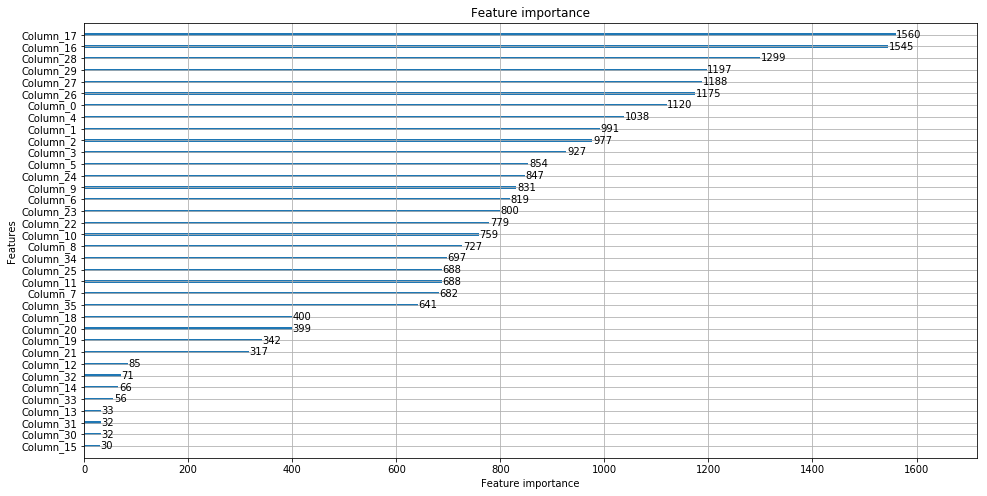

In [51]:
train = data[data.is_trade.notnull()]
test = data[data.is_trade.isnull()]

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

n_classes = 2

print('Train shape:', X_train.shape)
print('Test shape: ', X_test.shape)

def build_keras_model_1():
    model = Sequential()
    model.add(Dense(32, 
                    input_dim=X_train.shape[1], 
                    kernel_initializer='normal', 
                    activation='relu'))
    model.add(Dense(n_classes, 
                    kernel_initializer='normal', 
                    activation='softmax'))
    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'])
    return model

# Caution! All models and parameter values are just 
# demonstrational and shouldn't be considered as recommended.
models_1 = [ 
    GaussianNB(),
    
    LogisticRegression(random_state=0),
    
    ExtraTreesClassifier(random_state=0, n_jobs=-1, n_estimators=500, max_depth=3),
                         
    RandomForestClassifier(random_state=0, n_jobs=-1, n_estimators=500, max_depth=3),
        
    XGBClassifier(learning_rate=0.1, n_estimators=1000, max_depth=3),
                  
    LGBMClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, n_estimators=1000, max_depth=3),
                  
    KerasClassifier(build_fn=build_keras_model_1, epochs=2, batch_size=32, verbose=0)
]

S_train_1, S_test_1 = stacking(models_1,                   # list of models
                               X_train.fillna(0), y_train.fillna(0), X_test.fillna(0),   # data
                               regression=False,           # classification task (if you need 
                                                           #     regression - set to True)
                               mode='oof_pred',            # mode: oof for train set, fit on full 
                                                           #     train and predict test set once
                               needs_proba=True,           # predict probabilities (if you need 
                                                           #     class labels - set to False) 
                               save_dir='.',               # save result and log in current dir 
                                                           #     (to disable saving - set to None)
                               metric=log_loss,            # metric: callable
                               n_folds=5,                  # number of folds
                               stratified=True,            # stratified split for folds
                               shuffle=True,               # shuffle the data
                               random_state=0,             # ensure reproducibility
                               verbose=2)                  # print all info

names = sorted(glob('*.npy'))
npy_1_name = names[0] # for later use

print('Arrays:')
for name in names:
    print(name)

names = sorted(glob('*.log.txt'))
log_1_name = names[0] # for later use

print('\nLogs:')
for name in names:
    print(name)

def build_keras_model_2():
    model = Sequential()
    model.add(Dense(128, 
                    input_dim=X_train.shape[1], 
                    kernel_initializer='normal', 
                    activation='relu'))
    model.add(Dense(64, 
                    kernel_initializer='normal', 
                    activation='relu'))
    model.add(Dense(16, 
                    kernel_initializer='normal', 
                    activation='relu'))
    model.add(Dense(n_classes, 
                    kernel_initializer='normal', 
                    activation='softmax'))
    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy', 
                  metrics=['categorical_accuracy'])
    return model

# Caution! All models and parameter values are just 
# demonstrational and shouldn't be considered as recommended.
models_2 = [        
    KerasClassifier(build_fn=build_keras_model_2, epochs=5, batch_size=32, verbose=0),
    LGBMClassifier(random_state=0, n_jobs=-1, learning_rate=0.01, n_estimators=1700, max_depth=4, 
                   colsample_bytree=0.6, subsample=0.9,)
]

S_train_2, S_test_2 = stacking(models_2,                   # list of models
                               X_train.fillna(0), y_train.fillna(0), X_test.fillna(0),   # data
                               regression=False,           # classification task (if you need 
                                                           #     regression - set to True)
                               mode='oof_pred',            # mode: oof for train set, fit on full 
                                                           #     train and predict test set once
                               needs_proba=True,           # predict probabilities (if you need 
                                                           #     class labels - set to False) 
                               save_dir='.',               # save result and log in current dir 
                                                           #     (to disable saving - set to None)
                               metric=log_loss,            # metric: callable
                               n_folds=5,                  # number of folds
                               stratified=True,            # stratified split for folds
                               shuffle=True,               # shuffle the data
                               random_state=0,             # ensure reproducibility
                               verbose=2)                  # print all info

names = sorted(glob('*.npy'))

print('Arrays:')
for name in names:
    print(name)
    
names = sorted(glob('*.log.txt'))

print('\nLogs:')
for name in names:
    print(name)

print('We have %d classes and %d models TOTAL so in resulting arrays \
we expect to see %d columns.' % (n_classes, len(models_1) + len(models_2), 
                                 n_classes * (len(models_1) + len(models_2))))

# Create empty arrays
S_train_all = np.zeros((X_train.shape[0], 0))
S_test_all = np.zeros((X_test.shape[0], 0))

# Load results
for name in sorted(glob('*.npy')):
    print('Loading: %s' % name)
    S = np.load(name)
    S_train_all = np.c_[S_train_all, S[0]]
    S_test_all = np.c_[S_test_all, S[1]]
    
print('\nS_train_all shape:', S_train_all.shape)
print('S_test_all shape: ', S_test_all.shape)

# Initialize 2nd level model
model = LGBMClassifier(random_state=0, n_jobs=-1, learning_rate=0.01, n_estimators=1700, max_depth=4, 
                   colsample_bytree=0.6, subsample=0.9)
    
# Fit 2nd level model
model = model.fit(S_train_all, y_train)

# Predict
test['predicted_score'] = model.predict_proba(S_test_all)[:,1]

# Submit
result = test[['instance_id', 'predicted_score']]
result = pd.DataFrame(pd.read_csv(wd+test_file[1], sep=' ')['instance_id']).merge(result, on='instance_id', how='left').fillna(0)
print('\nsaving...')
result.to_csv(wd+output_file, sep=' ', index=False)

lgb.plot_importance(model, figsize=(16, 8))

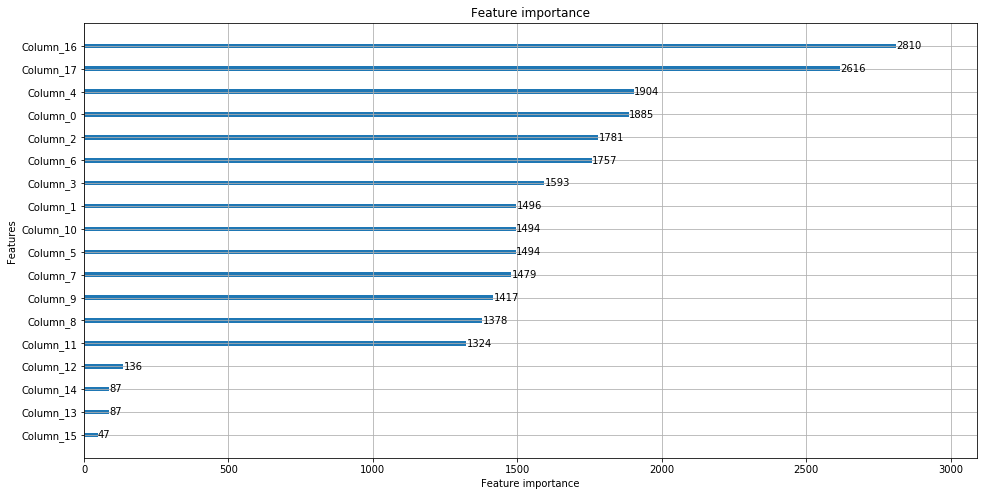